In [1]:
import unittest
from bvh import Bvh, BvhNode

In [81]:
import re

bvh_file = "coffee_1Char00.bvh"

def identifier(scanner, token):  return "IDENT", token
def operator(scanner, token):    return "OPERATOR", token
def digit(scanner, token):       return "DIGIT", token
def open_brace(scanner, token):  return "OPEN_BRACE", token
def close_brace(scanner, token): return "CLOSE_BRACE", token

current_token = 0

skeleton = {}
bone_context = []
motion_channels = []
motions = []
bodyParts = [[]]

def new_bone(parent, name):
	bone = { "parent" : parent, "channels" : [], "offsets" : []}
	return bone

def push_bone_context(name):
	global bone_context
	bone_context.append(name)

def get_bone_context():
	global bone_context
	return bone_context[len(bone_context)-1]

def pop_bone_context():
	global bone_context
	bone_context = bone_context[:-1]
	return bone_context[len(bone_context)-1]

reserved      = [ "HIERARCHY", "ROOT", "OFFSET", "CHANNELS", "MOTION" ]
channel_names = [ "Xposition", "Yposition", "Zposition",  "Yrotation", "Xrotation",  "Zrotation" ]

scanner = re.Scanner([
    (r"[a-zA-Z_]\w*", identifier),
    (r"-*[0-9]+(\.[0-9]+)?", digit),
	(r"}", close_brace),
	(r"{", open_brace),
	(r":", None),
    (r"\s+", None),
    ])

def read_offset(bvh, token_index):
	if (bvh[token_index] != ("IDENT", "OFFSET")):
		return None, None
	token_index = token_index + 1
	offsets = [ 0.0 ] * 3
	for i in range(0,3):
		offsets[i] = float(bvh[token_index][1])
		token_index = token_index + 1
	return  offsets, token_index

def read_channels(bvh, token_index):
	if (bvh[token_index] != ("IDENT", "CHANNELS")):
		return None, None
	token_index = token_index + 1
	channel_count = int(bvh[token_index][1])
	token_index = token_index+1
	channels = [ "" ] * channel_count
	for i in range(0, channel_count):
		channels[i] = bvh[token_index][1]
		token_index = token_index+1
	return channels, token_index

def parse_joint(bvh, token_index):
	end_site = False
	joint_id = bvh[token_index][1]
	token_index = token_index + 1
	joint_name = bvh[token_index][1]
	token_index = token_index + 1
	if (joint_id == "End"): # end site
		joint_name = get_bone_context() + "_Nub"
		end_site = True
	joint = new_bone(get_bone_context(), joint_name)
	if bvh[token_index][0] != "OPEN_BRACE":
		print ("Was expecting brace, got ", bvh[token_index])
		return None
	token_index = token_index + 1
	offsets, token_index = read_offset(bvh, token_index)
	joint["offsets"] = offsets
	if (not(end_site)):
		channels, token_index = read_channels(bvh, token_index)
		joint["channels"] = channels
		for channel in channels:
			motion_channels.append((joint_name, channel))
	skeleton[joint_name] = joint
	while (((bvh[token_index][0] == "IDENT") and (bvh[token_index][1] == "JOINT")) or
		  ((bvh[token_index][0] == "IDENT") and (bvh[token_index][1] == "End"))):
		push_bone_context(joint_name)
		token_index = parse_joint(bvh, token_index)
		pop_bone_context()
	if (bvh[token_index][0]) == "CLOSE_BRACE":
		return token_index + 1
	print ("Unexpected token ", bvh[token_index])

def parse_hierarchy(bvh):
	global current_token
	current_token = 0
	if (bvh[current_token] != ("IDENT", "HIERARCHY")):
		return None
	current_token = current_token + 1
	if (bvh[current_token] != ("IDENT", "ROOT")):
		return None
	current_token = current_token + 1
	if (bvh[current_token][0] != "IDENT"):
		return None
	root_name =bvh[current_token][1]
	root_bone = new_bone(None, root_name)
	current_token = current_token + 1
	if bvh[current_token][0] != "OPEN_BRACE":
		return None
	current_token = current_token + 1
	offsets, current_token = read_offset(bvh, current_token)
	channels, current_token = read_channels(bvh, current_token)
	root_bone["offsets"]  = offsets
	root_bone["channels"] = channels
	skeleton[root_name] = root_bone
	push_bone_context(root_name)
	print ("Root ", root_bone)
	while(bvh[current_token][1] == "JOINT"):
		current_token = parse_joint(bvh, current_token)


def parse_motion(bvh):
    global current_token
    if (bvh[current_token][0] != "IDENT"):
        print ("Unexpected text")
        return None
    if (bvh[current_token][1] != "MOTION"):
        print ("No motion section")
        return None
    current_token = current_token + 1
    if (bvh[current_token][1] != "Frames"):
        return None
    current_token = current_token  + 1
    frame_count = int(bvh[current_token][1])
    current_token = current_token  + 1
    if (bvh[current_token][1] != "Frame"):
        return None
    current_token = current_token  + 1
    if (bvh[current_token][1] != "Time"):
        return None
    current_token = current_token  + 1
    frame_rate = float(bvh[current_token][1])
    frame_time = 0.0
    motions = [ () ] * frame_count 
    requiredBodyParts = [] * frame_count
    for i in range(0, frame_count):
        #print ("Parsing frame ", i)
        channel_values = []
        for channel in motion_channels:
            channel_values.append((channel[0], channel[1], float(bvh[current_token][1])))
            current_token = current_token + 1
        motions[i] = (frame_time, channel_values)
        requiredBodyParts.append(channel_values[84:162])
        #print (channel_values[84:162])
        #print(requiredBodyParts[i])
        frame_time = frame_time + frame_rate
    #print(requiredBodyParts)
    return requiredBodyParts
        
#print (motions[i])
#[main_list[x] for x in indexes]

In [82]:

bvh_file = open("coffee_1Char00.bvh", "r")
bvh = bvh_file.read()
bvh_file.close()
tokens, remainder = scanner.scan(bvh)
parse_hierarchy(tokens)
for (name,bone) in skeleton.items():
    print ("Bone " + name);
    if "channels" in bone:
        print ("Channels ", bone["channels"])
    print ("Offsets ", bone["offsets"])
current_token = current_token + 1
requiredBodyParts = parse_motion(tokens)
#print(requiredBodyParts[1:30])
print("\n\n\n\n\ After reqBodyPart")

sizeList = len(requiredBodyParts)
rightForeArmXPosition = []*sizeList 
rightForeArmYPosition = []*sizeList 
rightForeArmZPosition = []*sizeList 
rightForeArmXRotation = []*sizeList 
rightForeArmYRotation = []*sizeList 
rightForeArmZRotation = []*sizeList 

rightHandXPosition = []*sizeList 
rightHandYPosition = []*sizeList 
rightHandZPosition = []*sizeList 
rightHandXRotation = []*sizeList 
rightHandYRotation = []*sizeList 
rightHandZRotation = []*sizeList 

for i in range(0,sizeList):
    rightForeArmXPosition.append (requiredBodyParts[i][0] )
    rightForeArmYPosition.append (requiredBodyParts[i][1] )
    rightForeArmZPosition.append (requiredBodyParts[i][2] )
    rightForeArmXRotation.append (requiredBodyParts[i][3] )
    rightForeArmYRotation.append (requiredBodyParts[i][4] )
    rightForeArmZRotation.append (requiredBodyParts[i][5] )
    
    rightHandXPosition.append (requiredBodyParts[i][6] )
    rightHandYPosition.append (requiredBodyParts[i][7] )
    rightHandZPosition.append (requiredBodyParts[i][8] )
    rightHandXRotation.append (requiredBodyParts[i][9] )
    rightHandYRotation.append (requiredBodyParts[i][10] )
    rightHandZRotation.append (requiredBodyParts[i][11] )

for i in range (0, sizeList):
    print (i,": ");
    print (rightForeArmXPosition[i])
    print (rightForeArmYPosition[i])
    print (rightForeArmZPosition[i])
    print (rightForeArmXRotation[i])
    print (rightForeArmYRotation[i])
    print (rightForeArmZRotation[i])
    
    print (rightHandXPosition[i])
    print (rightHandYPosition[i])
    print (rightHandZPosition[i])
    print (rightHandXRotation[i])
    print (rightHandYRotation[i])
    print (rightHandZRotation[i])
    
#print (len(rightForeArmXPosition))

#if "channels" in bone.has_key("channels")

Root  {'parent': None, 'channels': ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation'], 'offsets': [0.0, 93.594, 0.0]}
Bone Hips
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, 93.594, 0.0]
Bone RightUpLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [-9.5, -1.594, 0.0]
Bone RightLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, -42.0, 0.0]
Bone RightFoot
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, -42.0, 0.0]
Bone RightFoot_Nub
Channels  []
Offsets  [0.0, -8.0, 17.5]
Bone LeftUpLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [9.5, -1.594, 0.0]
Bone LeftLeg
Channels  ['Xposition', 'Yposition', 'Zposition', 'Yrotation', 'Xrotation', 'Zrotation']
Offsets  [0.0, -42.0, 0.0]
Bone LeftFoo

92 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
93 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Zrotation', -0.0)
94 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('R

('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', 12.722818)
('RightHand', 'Zrotation', -0.0)
235 : 
('RightForeArm', 'Xposition', 63.85141)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 36.309456)
('RightForeArm', 'Zrotation', 24.492947)
('RightHand', 'Xposition', -37.321945)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 4.777159)
('RightHand', 'Zrotation', -0.635327)
236 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 53.364857)
('RightForeArm', 'Zrotation', -21.764252)
('RightHand', 'Xposition', 63.849232)
('RightHand', 'Yposition', -27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 36.301941)
('RightHand', 'Zrotatio

('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
387 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
388 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 

('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
553 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Zrotation', -0.0)
554 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zpositi

699 : 
('RightForeArm', 'Xposition', 34.480972)
('RightForeArm', 'Yposition', -2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 34.480972)
('RightHand', 'Yposition', -3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
700 : 
('RightForeArm', 'Xposition', 34.468403)
('RightForeArm', 'Yposition', -3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 34.468403)
('RightHand', 'Yposition', -2.110737)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
701 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.365895)
('RightForeArm', 'Zposition', -0.0939

('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Zrotation', 0.0)
842 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
843 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Xrotation', 8.83)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
844 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposit

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
992 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 23.353701)
('RightHand', 'Yposition', -4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
993 : 
('RightForeArm', 'Xposition', 35.151585)
('RightForeArm', 'Yposition', -3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
994 : 
('RightFor

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 20.35457)
('RightHand', 'Yposition', -1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1161 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Xrotation', -25.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 20.292381)
('RightHand', 'Yposition', -2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1162 : 
('RightForeArm', 'Xposition', 20.09663)
('RightForeArm', 'Yposition', -3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightH

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1271 : 
('RightForeArm', 'Xposition', -30.0)
('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
1272 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zr

('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1422 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1423 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Yrotation', 0.0)
('Rig

('RightForeArm', 'Xposition', 51.16888)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 16.518148)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 9.812634)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 12.388611)
('RightHand', 'Zrotation', -0.0)
1590 : 
('RightForeArm', 'Xposition', 3.233975)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', 32.531246)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 51.166161)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 16.515781)
('RightHand', 'Zrotation', -0.0)
1591 : 
('RightForeArm', 'Xposition', -16.323753)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', '

('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 4.309327)
('RightHand', 'Zrotation', -0.168747)
1711 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 52.169426)
('RightForeArm', 'Zrotation', -25.178747)
('RightHand', 'Xposition', 51.794216)
('RightHand', 'Yposition', -27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 64.632645)
('RightHand', 'Zrotation', 25.399733)
1712 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 52.164951)
('RightH

('RightHand', 'Xrotation', 8.83)
('RightHand', 'Zrotation', -0.0)
1848 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1849 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.540733)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1850 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition'

('RightForeArm', 'Xposition', 28.996738)
('RightForeArm', 'Yposition', -2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 28.996738)
('RightHand', 'Yposition', -3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1998 : 
('RightForeArm', 'Xposition', 28.999266)
('RightForeArm', 'Yposition', -3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 28.999266)
('RightHand', 'Yposition', -2.110737)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
1999 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.365895)
('RightForeArm', 'Zposition', -0.093979)
(

2128 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.417054)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Zrotation', 0.0)
2129 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2130 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)

('RightHand', 'Zrotation', -0.0)
2283 : 
('RightForeArm', 'Xposition', 29.679361)
('RightForeArm', 'Yposition', -3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Xrotation', -25.0)
('RightHand', 'Zrotation', -0.0)
2284 : 
('RightForeArm', 'Xposition', 29.705435)
('RightForeArm', 'Yposition', -2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 29.705435)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.482779)
('RightHand', 'Yrotation', -1.236126)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2285 : 
('RightForeArm', 'Xposition', 29.73781)
('RightForeArm', 

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2447 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.110737)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2448 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2449 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition',

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 30.290001)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2584 : 
('RightForeArm', 'Xposition', 30.310505)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 30.310505)
('RightHand', 'Yposition', -2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2585 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightFo

('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2731 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Xrotation', 8.83)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2732 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -1.121684)
('RightHand', '

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2868 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 1e-06)
('RightForeArm', 'Zrotation', -1e-06)
('RightHand', 'Xposition', -66.801414)
('RightHand', 'Yposition', 27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
2869 : 
('RightForeArm', 'Xposition', 30.670422)
('RightForeArm', 'Yposition', 3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('Right

('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3012 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.417054)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Zrotation', -0.0)
3013 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightFor

('RightHand', 'Zposition', -1.5942)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
3142 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Zrotation', 0.0)
3143 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3144 : 
(

('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -11.500258)
('RightHand', 'Zrotation', -0.0)
3302 : 
('RightForeArm', 'Xposition', 11.379775)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 9.569856)
('RightForeArm', 'Zrotation', -3.118661)
('RightHand', 'Xposition', -5.830724)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', 18.507446)
('RightHand', 'Zrotation', -0.0)
3303 : 
('RightForeArm', 'Xposition', 59.612839)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 35.919781)
('RightForeArm', 'Zrotation', 60.338417)
('RightHand', 'Xposition', 11.759418)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotat

3446 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3447 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3448 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm',

('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -43.007458)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3587 : 
('RightForeArm', 'Xposition', -43.197029)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -43.197029)
('RightHand', 'Yposition', -2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3588 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)


('RightHand', 'Zrotation', -0.0)
3662 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.417054)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Zrotation', 0.0)
3663 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3664 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
(

('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3804 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.110737)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3805 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation

('RightHand', 'Xposition', 131.924774)
('RightHand', 'Yposition', -2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
3935 : 
('RightForeArm', 'Xposition', 131.902145)
('RightForeArm', 'Yposition', -3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Xrotation', -25.0)
('RightHand', 'Zrotation', -0.0)
3936 : 
('RightForeArm', 'Xposition', 131.895218)
('RightForeArm', 'Yposition', -2.456337)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 131.895218)
('RightHand', 'Yposition', -3.251369)
('RightHand', 'Zposition', 0.

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.417054)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Zrotation', 0.0)
4076 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.148685)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4077 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', '

('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 130.66069)
('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4233 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 130.640762)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4234 : 
('RightForeArm', 'Xposition', 130.612762)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
(

('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4376 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
4377 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('Righ

('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
4518 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Zrotation', -0.0)
4519 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('Rig

('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4657 : 
('RightForeArm', 'Xposition', 20.852421)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -32.028988)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.50396)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -24.02174)
('RightHand', 'Zrotation', -0.0)
4658 : 
('RightForeArm', 'Xposition', 15.77886)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', 8.276504)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 20.855265)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotati

('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4804 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4805 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Yrotat

('RightForeArm', 'Xposition', 128.457245)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Zrotation', -0.0)
4943 : 
('RightForeArm', 'Xposition', 128.436066)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 128.436066)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
4944 : 
('RightForeArm', 'Xposition', 128.424805)
('RightForeArm', 'Yposition', -4.062316)
('RightForeA

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
5084 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
5085 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 9.5)
(

('RightHand', 'Yposition', 3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5231 : 
('RightForeArm', 'Xposition', -40.230709)
('RightForeArm', 'Yposition', -2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -40.230709)
('RightHand', 'Yposition', -1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5232 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Xrotation', -25.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -40.266529)
('RightHand', 'Yposition', -2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'X

('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5375 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 10.148685)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5376 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand

('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5516 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 5.365895)
('RightForeArm', 'Zposition', -0.093979)
('RightForeArm', 'Yrotation', 1.027705)
('RightForeArm', 'Xrotation', -2.55)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5517 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Zrotatio

('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5652 : 
('RightForeArm', 'Xposition', 133.932373)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.932373)
('RightHand', 'Yposition', -2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5653 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 133.920334)
('RightHand', 'Yposition', -4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHa

('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Zrotation', -0.0)
5805 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5806 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposi

('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
5945 : 
('RightForeArm', 'Xposition', -35.500355)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Zrotation', -0.0)
5946 : 
('RightForeArm', 'Xposition', -35.542908)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -35.542908)
('RightHand', 'Yposition', -3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.1

('RightHand', 'Yposition', -2.456337)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6003 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -37.385273)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6004 : 
('RightForeArm', 'Xposition', -37.403687)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)

('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Zrotation', -0.0)
6159 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6160 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6161 : 
('RightForeArm', 'Xpositio

('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6302 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 126.76992)
('RightHand', 'Yposition', -4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6303 : 
('RightForeArm', 'Xposition', 112.659943)
('RightForeArm', 'Yposition', -3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Xrotation', 0.0)
('RightHand', '

('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Zrotation', 0.0)
6447 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6448 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotati

('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
6582 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
6583 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', -

('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Zrotation', 0.0)
6734 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 14.347799)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Zrotation', -0.0)
6735 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHa

('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6891 : 
('RightForeArm', 'Xposition', -30.876284)
('RightForeArm', 'Yposition', -4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.876284)
('RightHand', 'Yposition', -2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6892 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.684622)
('RightHand', 'Yposition', -4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
6893 : 
('RightForeArm', 'Xposition', 123.040802)
('Right

('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
7055 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Zrotation', -0.0)
7056 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('R

('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', 3.0)
('RightHand', 'Zrotation', -0.0)
7162 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.461305)
('RightHand', 'Zposition', 0.553263)
('RightHand', 'Yrotation', -0.132632)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7163 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 4.062316)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0

7306 : 
('RightForeArm', 'Xposition', 122.876663)
('RightForeArm', 'Yposition', -3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7307 : 
('RightForeArm', 'Xposition', 122.896622)
('RightForeArm', 'Yposition', -2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 122.896622)
('RightHand', 'Yposition', -3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7308 : 
('RightForeArm', 'Xposition', 122.921509)
('RightForeArm', 'Yposition', -3.722779)
('RightFore

7478 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.767158)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -25.946259)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7479 : 
('RightForeArm', 'Xposition', -26.154224)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Zrotation', -0.0)
7480 : 
('RightForeArm', 'Xposition', -26.387152)
('RightForeArm', 'Yposition', -2.546526)
('RightF

('RightForeArm', 'Zrotation', -28.852976)
('RightHand', 'Xposition', 9.383843)
('RightHand', 'Yposition', -27.000002)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 88.553902)
('RightHand', 'Zrotation', 46.181694)
7612 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.2)
('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -10.045689)
('RightHand', 'Zrotation', -28.881939)
7613 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.2)
('RightHand', 'Z

('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
7763 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', -21.860001)
('RightHand', 'Zrotation', -0.0)
7764 : 
('RightForeArm', 'Xposition', -66.801414)
('RightForeArm', 'Yposition', 27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 

7908 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
7909 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.417054)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Zrotation', -0.0)
7910 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('

('RightForeArm', 'Yposition', 3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.321937)
('RightHand', 'Zposition', -0.0864)
('RightHand', 'Yrotation', 0.322863)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8051 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 2.110737)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.478737)
('RightHand', 'Zposition', 0.532042)
('RightHand', 'Yrotation', 0.778358)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8052 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 3.722779)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightFore

('RightForeArm', 'Xposition', 15.610568)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -17.404364)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8197 : 
('RightForeArm', 'Xposition', 57.071827)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -22.229326)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 15.715396)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -16.671995)
('RightHand', 'Zrotation', -0.0)
8198 : 
('RightForeArm', 'Xposition', 7.368755)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposi

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
8332 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -9.5)
('RightForeArm', 'Zposition', -1.5942)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', -42.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
8333 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -42.113361)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposit

('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -0.492632)
('RightForeArm', 'Xrotation', -15.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -9.117524)
('RightHand', 'Yposition', -3.540733)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8482 : 
('RightForeArm', 'Xposition', -9.11322)
('RightForeArm', 'Yposition', -3.461305)
('RightForeArm', 'Zposition', 0.553263)
('RightForeArm', 'Yrotation', -0.132632)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.767158)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -0.492632)
('RightHand', 'Xrotation', -15.0)
('RightHand', 'Zrotation', -0.0)
8483 : 
('RightForeArm', 'Xposition', -9.113305)
('RightForeArm', 'Yposition', -2.546526)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotatio

('RightForeArm', 'Zposition', 9.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8617 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.417054)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', -0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Zrotation', -0.0)
8618 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.746131)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHan

('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 3.722779)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8762 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Zrotation', -0.0)
8763 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 3.31579)
('RightHand', 'Zposition', 

8903 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -3.31579)
('RightForeArm', 'Zposition', 0.522947)
('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Xrotation', 15.0)
('RightHand', 'Zrotation', -0.0)
8904 : 
('RightForeArm', 'Xposition', -3.423646)
('RightForeArm', 'Yposition', -2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -42.518089)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
8905 : 
('RightForeArm', 'Xposition', 37.913826)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Z

('RightForeArm', 'Zposition', 6.944703)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -12.799999)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -50.450726)
('RightHand', 'Zrotation', -47.157173)
9029 : 
('RightForeArm', 'Xposition', -0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 9.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -3.2)
('RightHand', 'Zposition', 6.944703)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9030 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 10.417054)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 3e-06)
('RightForeArm', 'Zrotation'

9177 : 
('RightForeArm', 'Xposition', -30.0)
('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
9178 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
9179 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', '

9318 : 
('RightForeArm', 'Xposition', 60.262501)
('RightForeArm', 'Yposition', -3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 23.311674)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 18.906096)
('RightHand', 'Yposition', -2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 17.483755)
('RightHand', 'Zrotation', -0.0)
9319 : 
('RightForeArm', 'Xposition', 15.833876)
('RightForeArm', 'Yposition', -2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', 35.983532)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 60.259125)
('RightHand', 'Yposition', -3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 23.419542)
('RightHand', 'Zrotation', -0.0)
9320 : 
('RightForeArm', 'Xposition', 55.463047)
('RightForeArm', 'Yposition', -26.0)
('RightF

('RightHand', 'Zposition', -1.5942)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
9455 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Zrotation', 0.0)
9456 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -24.0)
('RightHand', 'Yposition', 1.791663)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9457 : 
(

('RightForeArm', 'Yrotation', 2.034947)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 5.365895)
('RightHand', 'Zposition', -0.093979)
('RightHand', 'Yrotation', 1.027705)
('RightHand', 'Xrotation', -2.55)
('RightHand', 'Zrotation', -0.0)
9530 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.631411)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 3.31579)
('RightHand', 'Zposition', 0.522947)
('RightHand', 'Yrotation', 2.034947)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9531 : 
('RightForeArm', 'Xposition', -30.0)
('RightForeArm', 'Yposition', 3.787958)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xpos

('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -42.113361)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
9691 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Zrotation', 0.0)
9692 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotati

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9834 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -4.259368)
('RightForeArm', 'Zposition', -0.022737)
('RightForeArm', 'Yrotation', -1.121684)
('RightForeArm', 'Xrotation', -25.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 23.199833)
('RightHand', 'Yposition', -2.835284)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
9835 : 
('RightForeArm', 'Xposition', 23.178316)
('RightForeArm', 'Yposition', -3.251369)
('RightForeArm', 'Zposition', 0.482779)
('RightForeArm', 'Yrotation', -1.236126)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -4.259368)
('RightHand', 'Zposition', -0.022737)
('RightHand', 'Yrotation', -1.121684)
('RightHand', 'Xrotation', -25.0)
('RightHand', 'Zrotation', -0.0)
9836

('RightForeArm', 'Xrotation', 3.864529)
('RightForeArm', 'Zrotation', -5.132101)
('RightHand', 'Xposition', 3.361503)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', 30.205208)
('RightHand', 'Zrotation', -0.0)
9970 : 
('RightForeArm', 'Xposition', 40.912285)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 125.324997)
('RightForeArm', 'Zrotation', -29.315561)
('RightHand', 'Xposition', 64.751518)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 3.853518)
('RightHand', 'Zrotation', -5.097203)
9971 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -12.799999)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -71.787254)
('RightForeArm', 'Zrotation', -38.375107)
('Ri

('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 10.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 2.631411)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
10122 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 2.560169)
('RightForeArm', 'Zposition', 0.195537)
('RightForeArm', 'Yrotation', 3.209684)
('RightForeArm', 'Xrotation', -21.860001)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -30.0)
('RightHand', 'Yposition', 3.787958)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 10.0)
('RightHand', 'Zrotation', -0.0)
10123 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -

('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 17.134115)
('RightHand', 'Zrotation', -0.0)
10264 : 
('RightForeArm', 'Xposition', 65.279388)
('RightForeArm', 'Yposition', -26.0)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 4.119613)
('RightForeArm', 'Zrotation', -4.527545)
('RightHand', 'Xposition', 4.009194)
('RightHand', 'Yposition', -2.560169)
('RightHand', 'Zposition', 0.195537)
('RightHand', 'Yrotation', 3.209684)
('RightHand', 'Xrotation', 32.851749)
('RightHand', 'Zrotation', -0.0)
10265 : 
('RightForeArm', 'Xposition', 42.761578)
('RightForeArm', 'Yposition', -27.000002)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 122.602211)
('RightForeArm', 'Zrotation', -40.046268)
('RightHand', 'Xposition', 65.366417)
('RightHand', 'Yposition', -26.0)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 4.117712)
('RightHand', 'Zrota

('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 93.594193)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -42.113361)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', -9.5)
('RightHand', 'Zposition', -1.5942)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', 0.0)
10399 : 
('RightForeArm', 'Xposition', -24.0)
('RightForeArm', 'Yposition', 1.791663)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', -20.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 93.594193)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -42.113361)
('RightHand', 'Zrotation', 0.0)
10400 : 
('RightForeArm', 'Xposition', -20.0)
('RightForeArm', 'Yposition', 2.835284)
('RightForeArm', 'Zposition', 0.0)
('RightForeArm', 'Yrota

('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 15.539855)
('RightHand', 'Yposition', -2.546526)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10550 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', -5.321937)
('RightForeArm', 'Zposition', -0.0864)
('RightForeArm', 'Yrotation', 0.322863)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 15.534178)
('RightHand', 'Yposition', -4.062316)
('RightHand', 'Zposition', 0.0)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 0.0)
('RightHand', 'Zrotation', -0.0)
10551 : 
('RightForeArm', 'Xposition', 18.855984)
('RightForeArm', 'Yposition', -3.478737)
('RightForeArm', 'Zposition', 0.532042)
('RightForeArm', 'Yrotation', 0.778358)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHan

('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', 14.347799)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', -3e-06)
('RightForeArm', 'Zrotation', -0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 9.746131)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', 3e-06)
('RightHand', 'Zrotation', 0.0)
10687 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Yrotation', 0.0)
('RightForeArm', 'Xrotation', 0.0)
('RightForeArm', 'Zrotation', 0.0)
('RightHand', 'Xposition', 0.0)
('RightHand', 'Yposition', 0.0)
('RightHand', 'Zposition', 14.347799)
('RightHand', 'Yrotation', 0.0)
('RightHand', 'Xrotation', -3e-06)
('RightHand', 'Zrotation', -0.0)
10688 : 
('RightForeArm', 'Xposition', 0.0)
('RightForeArm', 'Yposition', 0.0)
('RightForeArm', 'Zposition', -42.0)
('RightForeArm', 'Yrotation', 0.0)
('Right

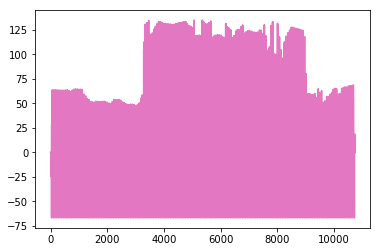

In [78]:
import matplotlib.pyplot as plt
import numpy as np

rightForeXPos = [];
for i in range(0,sizeList):
    rightForeXPos.append(rightForeArmXPosition[i][2])
plt.plot(range(0,sizeList), rightForeXPos)
plt.show()
